# LFV Higgs decays in SeeSaw model (Numeric approach)

As we have showed in the symbolic form factors notebook [FF_symbolic.ipynb](FF_symbolic.ipynb), 10 diagrams contributes to LFVHD in the seesaw model. The form factors associated to these diagrams have been calculated and we have shown that the divergencies cancel correctly. All of the diagrams are summarized by convenience in the symbolic form factors script [seesaw_FF.py](seesaw_FF.py). However, all of this calculations are based in the simbolic library sympy, now we need to transform the expressions of the form factors to numeric funtions to be evaluated. In order to do that, we import all diagrams from [seesaw_FF.py](seesaw_FF.py) and the usefull functions for libraries like sympy, mpmath, matplotlib, multiprocessing and finally all library OneLoopLFVHD.

In [1]:
from sympy import init_printing, Symbol,lambdify, symbols, Matrix
init_printing()
import OneLoopLFVHD as lfvhd

In [2]:
from seesaw_FF import TrianglesOneFermion, TrianglesTwoFermion, Bubbles,DiagramsOneFermionW, DiagramsOneFermionG
from seesaw_FF import g, mW, Uν, Uνc, mn, m, C, Cc, a,b,i,h
from seesaw_FF import j as jj

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from mpmath import *

In [5]:
mp.dps = 80; mp.pretty = True

In [6]:
import numpy as np

In [7]:
#import subprocess as s

In [8]:
from multiprocessing import Pool
#from time import time

In [9]:
def speedup_array(f,array,procs=4): 
    pool = Pool(procs,maxtasksperchild=100).map(f, array)
    result = np.array(list(pool))
    return result

## Neutrino oscillation and lepton data

Neutrino benchmark is given by 

In [10]:
from OneLoopLFVHD.neutrinos import NuOscObservables
Nudata = NuOscObservables

In [11]:
m1 = mpf('1e-12')  #GeV 

#current values to Square mass differences
d21 = mpf(str(Nudata.squareDm21.central))*mpf('1e-18')# factor to convert eV^2 to GeV^2
d31 = mpf(str(Nudata.squareDm31.central))*mpf('1e-18')

#d21 = 7.5e-5*1e-18
#d31 = 2.457e-3*1e-18
m2 = sqrt(m1**2 + d21)
m3 = sqrt(m1**2 + d31)

m4 = lambda m6: m6/3
m5 = lambda m6: m6/2

We calls from [Unu_seesaw.py](Unu_seesaw.py) the `diagonalizationMnu` function previously created to perform numerically the diagonalization of $6 \times 6$ mass matrix. Here we choose which scenary for heavy neutrino we consider.

In [12]:
# from Unu_seesaw_ISS import diagonalizationMnu_ISS_svd as diagonalizationMnu
from Unu_seesaw_ISS import diagonalizationMnu_ISS as diagonalizationMnu
from Unu_seesaw_ISS import Mnu

diagonalizationMnu1 = lambda MR,mux: diagonalizationMnu(
    m1,m2,m3,MR,MR,MR,mux,mux,mux)


In [13]:
mnk, UL,UR = diagonalizationMnu1(mp.mpf('1e7'),mp.mpf('1e-8'))#0.003908
mp.nprint(mnk)

[(-9.9995e+6 + 0.0j), (-9.99567e+6 + 0.0j), (-9.97485e+6 + 0.0j), (-5.04931e-11 + 0.0j), (-8.66198e-12 + 0.0j), (-1.0001e-12 + 0.0j), (9.97485e+6 + 0.0j), (9.99567e+6 + 0.0j), (9.9995e+6 + 0.0j)]


We introduce the values to $g$, $m_W$, $m_h$ and leptons masses, which will be susbtitute in the simbolic expressions.

In [14]:
from OneLoopLFVHD.data import ml

In [15]:
mh,ma,mb = symbols('m_h,m_a,m_b',real=True)
valores ={mW:mpf('80.379'),mh:mpf('125.10'),g:(2*mpf('80.379'))/mpf('246')}

cambios_hab = lambda a,b:{lfvhd.ma:valores[mh],lfvhd.mi:ml[a],lfvhd.mj:ml[b]}

## Diagrams with one fermion in the loop.

In the case of diagram with only one neutrino in the loop which are labeled by the index $i$. the diagrams are 8 which are stored in `TrianglesOneFermion` and `Bubbles` lists.To other side, we need to consider a summatory of 6 neutrino generation and the GIM mechanism. First we do a auxiliar simbolic substitutions related to the following code.

In [16]:
Ubi, Ucai,mni = symbols('U_{bi}, {{U_{ai}^*}},m_{n_i}')
UnuOne = {mn[i]:mni,Uν[b,i]:Ubi,Uνc[a,i]:Ucai}

A simple implementation to the GIM mechanism to any simbolic form factor

In [17]:
def GIM_One(exp, fermion_mass):
    '''
    Function to apply the GIM mechanism in the form factors from diagrams with one neutrino in the loop 
    (This function is adapted only to this model seesaw and this notebook). 
    
    input
    ---------
        exp: must be a form factor taken from a diagram of OneLoopLFVHD.
    
    Return
    ---------
        OneLoopLFVHD expresion (sympy expression): The output is the resultant form factor simplified by
        the GIM mechanism, Only return the term which contains mni. 
    '''
    from sympy import Add
    args = exp.expand().args
    func = exp.expand().func
    if isinstance(func,Add):
        exp_GIM = Add(*[t for t in args if t.has(fermion_mass)]).simplify()
    else:
        exp_GIM = exp
    return exp_GIM

When we create our numeric functions from symblic form factors we will sum over the neutrino generations by the function `sumOne`

In [18]:
def sumOne(MR,mux,Aab,a,b): 
    '''
    Function which sums over neutrino generation conidering the structure of Upmns matrix before calculated.
    
    Input
    --------
        m6 (float): the haviet mass
        Aab: funtion asociated to form factor
        a,b (int): indexes of leptons a,b=1,2 or 3
        
    Output
    --------
        out (float): numeric summation of the form factor over the 6 neutrino generations.
    '''
    mnk,UnuL,UnuR = diagonalizationMnu1(MR,mux)
    Unu = UnuR
    Unu_dagger = UnuL
    FF = []
    for k in range(1,10):
        #A = Aab(mnk[k-1],Unu[b-1,k-1],conj(Unu[a-1,k-1]))
        A = Aab(mnk[k-1],Unu[b-1,k-1],Unu_dagger[k-1,a-1])
        #print('Ai = ',A)
        FF.append(A)
    out = mp.fsum(FF)
    return out


Now, we build a main function to convert the symbolic form factor to numeric functions. This function is given below

In [19]:
from OneLoopLFVHD.data import replaceBs, pave_functions # Auxiliary functions

In [20]:
def numeric_sum_diagramsOne(a,b,quirality='L'):
    '''
    This function create a function which only depends on m6 and represent the sum of all form factors
    associated to diagrams with one fermion in the loop and also considering the 6 neutrino generations.
    
    Input
    ---------
        a,b (int): indexes of leptons, a,b = 1,2 or 3
        quirality (string): represents the chirality of the diagrams, it can be L or R:
        
    Output:
        sum_over_index_i (function): returns the function which represent the sum of all diagrams and 
        over the neutrino index i. This function only depends on m6.
    '''
    #[TrianglesOneFermion[0],TrianglesOneFermion[1],TrianglesOneFermion[2]],
    #[bubbleniG,bubbleGni]
    FFOneFer_list = []
    for Set in [TrianglesOneFermion,Bubbles]:#TrianglesOneFermion,Bubbles
        for dia in Set:
            if quirality=='L':
                x = dia.AL().subs(lfvhd.D,4).subs(lfvhd.B12_0(mW,mW),0).subs(cambios_hab(a,b)).subs(valores).subs(UnuOne)
            elif quirality=='R':
                x = dia.AR().subs(lfvhd.D,4).subs(lfvhd.B12_0(mW,mW),0).subs(cambios_hab(a,b)).subs(valores).subs(UnuOne)
            else:
                raise ValueError('quirality must be L or R')
            f = lambdify([mni,Ubi,Ucai],# depends on three parameters
                         replaceBs(x), # replace B function by auxiliary functions which do not has problembs in lambdify
                         modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath']
                        ) #numeric Form factor
            #print(f(1,2,3))
            #fsum = lambda m6:sumOne(m6,f,a,b)
            FFOneFer_list.append(f)
    def sum_over_index_i(MR,mux):
        out = []
        #xs = []
        for FFab in FFOneFer_list:
            FF_sum_over_i = sumOne(MR,mux,FFab,a,b) # sum over neutrino generations
            out.append(FF_sum_over_i)
            #xs.append(FF_sum_over_i)
        return np.array(out), mp.fsum(out)
    return sum_over_index_i

In [21]:
nprint(chop(abs(numeric_sum_diagramsOne(3,1,quirality='R')(1e7,1e-8)[1])))

0.271109


In [22]:
def ALOneTot23(MR,mux):
    return numeric_sum_diagramsOne(2,3,quirality='L')(MR,mux)[1]
def AROneTot23(MR,mux):
    return numeric_sum_diagramsOne(2,3,quirality='R')(MR,mux)[1]

# def ALOneTot32(MR,mux):
#     return numeric_sum_diagramsOne(3,2,quirality='L')(MR,mux)[1]
# def AROneTot32(MR,mux):
#     return numeric_sum_diagramsOne(3,2,quirality='R')(MR,mux)[1]

def ALOneTot13(MR,mux):
    return numeric_sum_diagramsOne(1,3,quirality='L')(MR,mux)[1]
def AROneTot13(MR,mux):
    return numeric_sum_diagramsOne(1,3,quirality='R')(MR,mux)[1]

# def ALOneTot31(MR,mux):
#     return numeric_sum_diagramsOne(3,1,quirality='R')(MR,mux)[1]
# def AROneTot31(MR,mux):
#     return numeric_sum_diagramsOne(3,1,quirality='L')(MR,mux)[1]

def ALOneTot12(MR,mux):
    return numeric_sum_diagramsOne(1,2,quirality='L')(MR,mux)[1]
def AROneTot12(MR,mux):
    return numeric_sum_diagramsOne(1,2,quirality='R')(MR,mux)[1]

# def ALOneTot21(MR,mux):
#     return numeric_sum_diagramsOne(2,1,quirality='L')(MR,mux)[1]
# def AROneTot21(MR,mux):
#     return numeric_sum_diagramsOne(2,1,quirality='R')(MR,mux)[1]

In [23]:
nprint(chop(ALOneTot23(1,1e-8)))

-7.42579e-13


Now to plot we choose the interval $m_{n_6} \in [10^{-1},10^{15}]$

In [24]:
n = 20
expmp = linspace(-1,15,n)
MRnp = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)

Now, we evaluate our form factor numeric function in the chose interval. To do a faster evaluation we use `speedup_array` function

In [46]:
%%time
mux=mpf('1e-8')
def ALOneTot23_mux1(MR): return ALOneTot23(MR,mux)
YLOne23 = speedup_array(ALOneTot23_mux1,MRnp)

def ALOneTot13_mux1(MR): return ALOneTot13(MR,mux)
YLOne13 = speedup_array(ALOneTot13_mux1,MRnp)

def ALOneTot12_mux1(MR): return ALOneTot12(MR,mux)
YLOne12 = speedup_array(ALOneTot12_mux1,MRnp)

CPU times: user 398 ms, sys: 182 ms, total: 580 ms
Wall time: 3min 6s


Finalli we can plot the behavior of the sum of form factor for diagrams with one fermion.

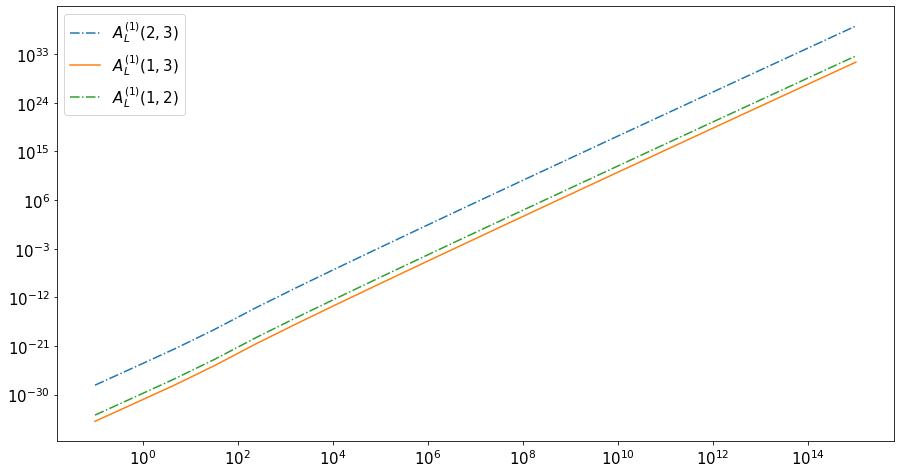

In [47]:
plt.figure(figsize=(15,8))
plt.loglog(np.real(MRnp),abs(YLOne23)**2,'-.',label='$A_L^{(1)}(2,3)$')
#plt.loglog(np.real(m6np),abs(YLOne32)**2,'--',label='$A_L^{(1)}(3,2)$')

plt.loglog(np.real(MRnp),abs(YLOne13)**2,'-',label='$A_L^{(1)}(1,3)$')
#plt.loglog(np.real(m6np),abs(YLOne31)**2,'--',label='$A_L^{(1)}(3,1)$')

plt.loglog(np.real(MRnp),abs(YLOne12)**2,'-.',label='$A_L^{(1)}(1,2)$')
#plt.loglog(np.real(m6np),abs(YLOne21)**2,'--',label='$A_L^{(1)}(2,1)$')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15)

## Form factor with two fermion in the loop.

In this case we only have 2 diagrams stored in `TrianglesTwoFermion` list. In this case we have two neutrino indexes $i$ and $j$.Then, we have a doble summatory in this case.  First we do an auxiliar simbolic substitutions related to the following code

In [48]:
mnj = symbols('m_{n_j}',positive=True)
Cijs, Cijcs, Ubj = symbols('C_{ij}, {{C_{ij}^*}},U_{bj}')
UnuTwo = {mn[i]:mni,mn[jj]:mnj,C[i,jj]:Cijs, Cc[i,jj]:Cijcs, Uν[b,jj]:Ubj, Uνc[a,i]:Ucai}
UnuTwo

In [49]:
fsL = lambda k,a,b:TrianglesTwoFermion[k].AL().subs(lfvhd.D,4).subs(cambios_hab(a,b)).subs(valores).subs(UnuTwo)
fsR = lambda k,a,b:TrianglesTwoFermion[k].AR().subs(lfvhd.D,4).subs(cambios_hab(a,b)).subs(valores).subs(UnuTwo)

In [50]:
fL = lambda k,a,b:lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(fsL(k,a,b)),
                     modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath'] )
fR = lambda k,a,b:lambdify([mni,mnj,Ubj,Ucai,Cijs,Cijcs],replaceBs(fsR(k,a,b)),
                     modules=[pave_functions(valores[mh],a,b,lib='mpmath'),'mpmath'] )

In [51]:
nprint(chop(fL(0,2,3)(1,2,3,4,5,6)))

(-2.7248e-7 + 1.6352e-7j)


Now, we do a function to do the doble summatory on the neutrino generetions

In [52]:
def sumatwo(MR,mux,k,a,b,quirality='L'):
    xs = []
    if quirality=='L':
        g = fL(k,a,b)
    elif quirality=='R':
        g = fR(k,a,b)
    else:
        raise ValueError('quirality must be L or R')
        
    mnk,UnuL,UnuR = diagonalizationMnu1(MR,mux)
    Unu = UnuR
    Unu_dagger = UnuL
    #Cij = lambda i,j: mp.fsum([Unu[c,i]*conj(Unu[c,j]) for c in range(3)])
    Cij = lambda i,j: mp.fsum([Unu[c,i]*Unu_dagger[j,c] for c in range(3)])
    for p in range(1,10):
        for q in range(1,10):
            #x = g(
            # mnk[p-1],mnk[q-1],Unu[b-1,q-1],conj(Unu[a-1,p-1]),
            # Cij(p-1,q-1),conj(Cij(p-1,q-1))
            # )
            x = g(
                mnk[p-1],mnk[q-1],Unu[b-1,q-1],Unu_dagger[p-1,a-1],
                Cij(p-1,q-1),conj(Cij(p-1,q-1))
                )
            xs.append(x)
            #print(f'i = {p} and j = {q}')
            #print(f'|f| = {x}')
    return mp.fsum(xs)

Then the total contribution of the diagrams with two fermions in the loop is given by

In [53]:
def totaltwo(MR,mux,a,b,quirality='L'):
    return sumatwo(MR,mux,0,a,b,quirality)  + sumatwo(MR,mux,1,a,b,quirality)

In [54]:
ALTwoTot23 = lambda MR,mux: totaltwo(MR,mux,2,3,'L')
ARTwoTot23 = lambda MR,mux: totaltwo(MR,mux,2,3,'R')

# ALTwoTot32 = lambda m6: totaltwo(m6,3,2,'L')
# ARTwoTot32 = lambda m6: totaltwo(m6,3,2,'R')

ALTwoTot13 = lambda MR,mux: totaltwo(MR,mux,1,3,'L')
ARTwoTot13 = lambda MR,mux: totaltwo(MR,mux,1,3,'R')

# ALTwoTot31 = lambda m6: totaltwo(m6,3,1,'L')
# ARTwoTot31 = lambda m6: totaltwo(m6,3,1,'R')

ALTwoTot12 = lambda MR,mux: totaltwo(MR,mux,1,2,'L')
ARTwoTot12 = lambda MR,mux: totaltwo(MR,mux,1,2,'R')

# ALTwoTot21 = lambda m6: totaltwo(m6,2,1,'L')
# ARTwoTot21 = lambda m6: totaltwo(m6,2,1,'R')

In [38]:
#abs(ALTwoTot23(m6np[-1])),abs(sumatwo(m6np[-1],0,2,3,'L')+ sumatwo(m6np[-1],1,2,3,'L'))

## Total Form Factors

Finally, if we sum the contribution of one and two fermions, we obtain the total fomr factors given as follows

In [55]:
mux0 = mpf('1e-7')

#a = 2, b = 3
def ALtot23(MR,mux=mux0):
    return  ALOneTot23(MR,mux) + ALTwoTot23(MR,mux)
def ARtot23(MR,mux=mux0):
    return  AROneTot23(MR,mux) + ARTwoTot23(MR,mux)

#a = 3, b = 2
# def ALtot32(m6):
#     return  ALOneTot32(m6) + ALTwoTot32(m6)
# def ARtot32(m6):
#     return  AROneTot32(m6) + ARTwoTot32(m6)

#a = 1, b = 3
def ALtot13(MR,mux=mux0):
    return  ALOneTot13(MR,mux) + ALTwoTot13(MR,mux)
def ARtot13(MR,mux=mux0):
    return  AROneTot13(MR,mux) + ARTwoTot13(MR,mux)

#a = 3, b = 1
# def ALtot31(m6):
#     return  ALOneTot31(m6) + ALTwoTot31(m6)
# def ARtot31(m6):
#     return  AROneTot31(m6) + ARTwoTot31(m6)

#a = 1, b = 2
def ALtot12(MR,mux=mux0):
    return  ALOneTot12(MR,mux) + ALTwoTot12(MR,mux)
def ARtot12(MR,mux=mux0):
    return  AROneTot12(MR,mux) + ARTwoTot12(MR,mux)

#a = 2, b = 1
# def ALtot21(m6):
#     return  ALOneTot21(m6) + ALTwoTot21(m6)
# def ARtot21(m6):
#     return  AROneTot21(m6) + ARTwoTot21(m6)

## Width decay of $h \to e_a e_b$

As we know the width decay of the decay $h \to e_a e_b$ depends on the total left and right form factors ,and the masses of the higgs and the leptons. However we have this definition our library, then,

In [56]:
Γhlilj = lfvhd.Γhlilj

In [57]:
def Γhl2l3(MR):
    return Γhlilj(ALtot23(MR),ARtot23(MR),valores[mh],ml[2],ml[3])
# def Γhl3l2(m6):
#     return Γhlilj(ALtot32(m6),ARtot32(m6),valores[mh],ml[3],ml[2])

def Γhl1l3(MR):
    return Γhlilj(ALtot13(MR),ARtot13(MR),valores[mh],ml[1],ml[3])
# def Γhl3l1(m6):
#     return Γhlilj(ALtot31(m6),ARtot31(m6),valores[mh],ml[3],ml[1])

def Γhl1l2(MR):
    return Γhlilj(ALtot12(MR),ARtot12(MR),valores[mh],ml[1],ml[2])
# def Γhl2l1(m6):
#     return Γhlilj(ALtot21(m6),ARtot21(m6),valores[mh],ml[2],ml[1])

As we show before the width decay of $h \to e_a e_b$ to a specific chanel depends only on $m_{n_6}$. remeber that we are consider the interval for the heavies neutrino mass $m_{n_6} \in [10^{-1}, 10^{15}]$.

In [60]:
n = 30
expmp = linspace(3,7,n)
MRnp = np.array([mpf('10.0')**k for k in expmp])#np.logspace(-1,15,n)
# MRnp = linspace(1e2,1e7,n)

Then, we evaluate the widths in this range

In [61]:
%%time
YW23 = speedup_array(Γhl2l3,MRnp)
#YW32 = speedup_array(Γhl3l2,m6np)

YW13 = speedup_array(Γhl1l3,MRnp)
#YW31 = speedup_array(Γhl3l1,m6np)

YW12 = speedup_array(Γhl1l2,MRnp)

#YW21 = speedup_array(Γhl2l1,m6np)

CPU times: user 14.7 s, sys: 5.28 s, total: 20 s
Wall time: 1h 24min 34s


We calculate the total width as follows

In [62]:
WidthSM = 0.0032 #GeV
Wtot = YW23 + YW13 + YW12 + WidthSM# + YW32 + YW31 + YW21

## Plot

Finally, we plot the branchig ratios of each channel as follows 

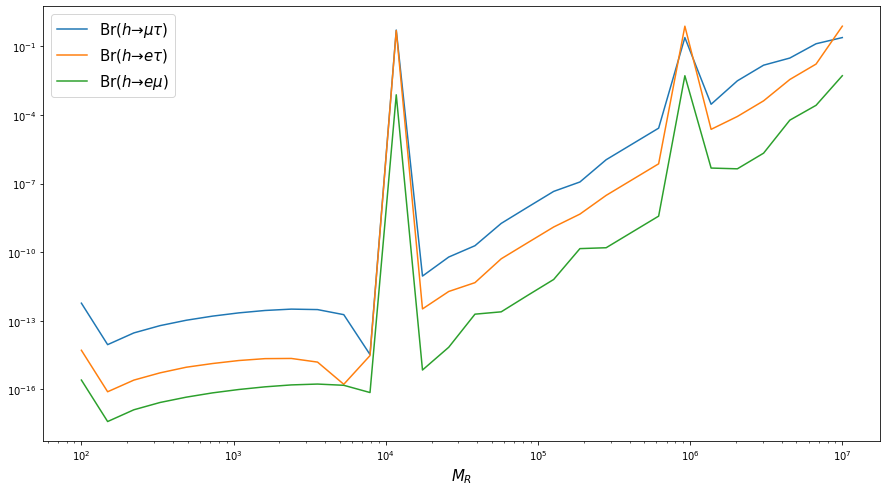

: 

In [63]:
plt.figure(figsize=(15,8))
plt.loglog(np.real(MRnp),(YW23 #+ YW32
                         )/Wtot,label=r'Br($h \to \mu \tau$)')
plt.loglog(np.real(MRnp),(YW13 #+ YW31
                         )/Wtot,label=r'Br($h \to e \tau$)')
plt.loglog(np.real(MRnp),(YW12 #+ YW21
                         )/Wtot,label=r'Br($h \to e \mu$)')

#xx = ((YW23 + YW32)/Wtot)[-1]
#plt.hlines(1e-10,0.1,1e15,linestyles='-.',label=r'$1.7\times 10^{-2}$')
#plt.hlines(5e-43,0.1,1e15,linestyles='--',color='b',label=r'$1\times 10^{-32}$')
#plt.vlines(125.1,5e-43,1e-10,linestyles='--',color='r',label=r'$m_h$')
#plt.vlines(80.379,5e-43,1e-10,linestyles='--',color='g',label=r'$m_W$')
#plt.xlim(200,1e7)
#plt.yticks([1e-39,1e-29,1e-19,1e-9,1])
#plt.xticks([1,1e4,1e8,1e12,1e16])
plt.xlabel('$M_R$',fontsize=15)
plt.legend(fontsize=15)

## Import data

In [40]:
import pandas as pd

In [41]:
df = pd.DataFrame({'MR':MRnp,
                   'Whl2l3':YW23,
                   #'Whl3l2':YW32,
                   'Whl1l3':YW13,
                   #'Whl3l1':YW31,
                   'Whl1l2':YW12})
                   #'Whl2l1':YW21})

In [42]:
df.to_csv('LFVHD-3_ISS.txt',sep='\t')

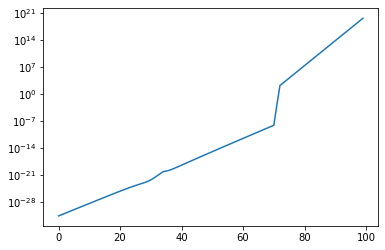

In [43]:
plt.semilogy(np.array(list(map(mpf,df['Whl2l3']))))